# California Wildfire Data Analysis

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import geopandas as gpd

# Load the dataset with specified dtypes
dtype_dict = {
    'Incident Start Date': 'str',
    'Fire Name (Secondary)': 'str',
    'APN (parcel)': 'str'
}
data = pd.read_csv('CAL_POSTFIRE.csv', dtype=dtype_dict, low_memory=False)

# Display the first few rows of the dataset
data.head()

,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)","Street Suffix (e.g. apt. 23, blding C)",* City,State,Zip Code,* CAL FIRE Unit,...,Fire Name (Secondary),APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,x,y
0,1,No Damage,8376.0,Quail Canyon,Road,NaN,Winters,CA,NaN,LNU,...,Quail,0101090290,510000.0,1997.0,8376 QUAIL CANYON RD VACAVILLE CA 95688,e1919a06-b4c6-476d-99e5-f0b45b070de8,38.474960,-122.044465,-1.358593e+07,4.646741e+06
1,2,Affected (1-9%),8402.0,Quail Canyon,Road,NaN,Winters,CA,NaN,LNU,...,Quail,0101090270,573052.0,1980.0,8402 QUAIL CANYON RD VACAVILLE CA 95688,b090eeb6-5b18-421e-9723-af7c9144587c,38.477442,-122.043252,-1.358579e+07,4.647094e+06
2,3,No Damage,8430.0,Quail Canyon,Road,NaN,Winters,CA,NaN,LNU,...,Quail,0101090310,350151.0,2004.0,8430 QUAIL CANYON RD VACAVILLE CA 95688,268da70b-753f-46aa-8fb1-327099337395,38.479358,-122.044585,-1.358594e+07,4.647366e+06
3,4,No Damage,3838.0,Putah Creek,Road,NaN,Winters,CA,NaN,LNU,...,Quail,0103010240,134880.0,1981.0,3838 PUTAH CREEK RD WINTERS CA 95694,64d4a278-5ee9-414a-8bf4-247c5b5c60f9,38.487313,-122.015115,-1.358266e+07,4.648497e+06
4,5,No Damage,3830.0,Putah Creek,Road,NaN,Winters,CA,NaN,LNU,...,Quail,0103010220,346648.0,1980.0,3830 PUTAH CREEK RD WINTERS CA 95694,1b44b214-01fd-4f06-b764-eb42a1ec93d7,38.485636,-122.016122,-1.358277e+07,4.648259e+06


## Data Preprocessing

In [82]:
# Check for missing values
data.isnull().mean() *100

OBJECTID                                                         0.000000
* Damage                                                         0.000000
* Street Number                                                  3.381221
* Street Name                                                    4.196692
* Street Type (e.g. road, drive, lane, etc.)                    11.063172
Street Suffix (e.g. apt. 23, blding C)                          52.558100
* City                                                          24.273649
State                                                            0.005355
Zip Code                                                        40.417833
* CAL FIRE Unit                                                  0.000000
County                                                           0.022949
Community                                                       58.127936
Battalion                                                       94.954178
* Incident Name                       

In [83]:
# Calculate the threshold for missing values
threshold = len(data) * 0.65

# Drop columns with more than 65% missing values
data_cleaned = data.dropna(thresh=threshold, axis=1)

# Display the remaining columns
data_cleaned.head()

,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)",* City,State,* CAL FIRE Unit,County,* Incident Name,...,* Fence Attached to Structure,APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,x,y
0,1,No Damage,8376.0,Quail Canyon,Road,Winters,CA,LNU,Solano,Quail,...,No Fence,0101090290,510000.0,1997.0,8376 QUAIL CANYON RD VACAVILLE CA 95688,e1919a06-b4c6-476d-99e5-f0b45b070de8,38.474960,-122.044465,-1.358593e+07,4.646741e+06
1,2,Affected (1-9%),8402.0,Quail Canyon,Road,Winters,CA,LNU,Solano,Quail,...,Combustible,0101090270,573052.0,1980.0,8402 QUAIL CANYON RD VACAVILLE CA 95688,b090eeb6-5b18-421e-9723-af7c9144587c,38.477442,-122.043252,-1.358579e+07,4.647094e+06
2,3,No Damage,8430.0,Quail Canyon,Road,Winters,CA,LNU,Solano,Quail,...,No Fence,0101090310,350151.0,2004.0,8430 QUAIL CANYON RD VACAVILLE CA 95688,268da70b-753f-46aa-8fb1-327099337395,38.479358,-122.044585,-1.358594e+07,4.647366e+06
3,4,No Damage,3838.0,Putah Creek,Road,Winters,CA,LNU,Solano,Quail,...,No Fence,0103010240,134880.0,1981.0,3838 PUTAH CREEK RD WINTERS CA 95694,64d4a278-5ee9-414a-8bf4-247c5b5c60f9,38.487313,-122.015115,-1.358266e+07,4.648497e+06
4,5,No Damage,3830.0,Putah Creek,Road,Winters,CA,LNU,Solano,Quail,...,No Fence,0103010220,346648.0,1980.0,3830 PUTAH CREEK RD WINTERS CA 95694,1b44b214-01fd-4f06-b764-eb42a1ec93d7,38.485636,-122.016122,-1.358277e+07,4.648259e+06


In [84]:
# Display basic statistics of the dataset
data.describe()

,OBJECTID,* Street Number,Zip Code,# Units in Structure (if multi unit),# of Damaged Outbuildings < 120 SQFT,# of Non Damaged Outbuildings < 120 SQFT,Assessed Improved Value (parcel),Year Built (parcel),Latitude,Longitude,x,y
count,130722.000000,1.263020e+05,77887.000000,38908.000000,40915.000000,40923.000000,1.238310e+05,99259.000000,130722.000000,130722.000000,1.307220e+05,1.307220e+05
mean,65688.380028,3.049720e+04,63248.626112,0.464326,0.078822,0.108594,7.399900e+05,1755.206117,37.345905,-120.506903,-1.341477e+07,4.493210e+06
std,38126.433935,4.591477e+06,43095.528223,31.016093,0.423407,0.489252,9.507596e+06,607.842358,2.502964,1.819625,2.025598e+05,3.490361e+05
min,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,32.592548,-123.774580,-1.377852e+07,3.841346e+06
25%,32681.250000,6.900000e+02,0.000000,0.000000,0.000000,0.000000,7.173200e+04,1940.000000,34.195297,-122.128623,-1.359530e+07,4.055056e+06
50%,65361.500000,3.058000e+03,91001.000000,0.000000,0.000000,0.000000,1.650000e+05,1962.000000,38.467951,-121.396271,-1.351377e+07,4.645744e+06
75%,99032.750000,8.500000e+03,93010.000000,0.000000,0.000000,0.000000,3.465480e+05,1983.000000,39.741065,-118.542113,-1.319605e+07,4.828386e+06
max,131869.000000,1.410065e+09,96311.000000,6101.000000,40.000000,20.000000,1.220403e+09,2022.000000,41.991195,-116.418163,-1.295961e+07,5.159661e+06


In [85]:
data.columns

Index(['OBJECTID', '* Damage', '* Street Number', '* Street Name',
       '* Street Type (e.g. road, drive, lane, etc.)',
       'Street Suffix (e.g. apt. 23, blding C)', '* City', 'State', 'Zip Code',
       '* CAL FIRE Unit', 'County', 'Community', 'Battalion',
       '* Incident Name', 'Incident Number (e.g. CAAEU 123456)',
       'Incident Start Date', 'Hazard Type',
       'If Affected 1-9% - Where did fire start?',
       'If Affected 1-9% - What started fire?',
       'Structure Defense Actions Taken', '* Structure Type',
       'Structure Category', '# Units in Structure (if multi unit)',
       '# of Damaged Outbuildings < 120 SQFT',
       '# of Non Damaged Outbuildings < 120 SQFT', '* Roof Construction',
       '* Eaves', '* Vent Screen', '* Exterior Siding', '* Window Pane',
       '* Deck/Porch On Grade', '* Deck/Porch Elevated',
       '* Patio Cover/Carport Attached to Structure',
       '* Fence Attached to Structure', 'Distance - Propane Tank to Structure',
       'Dis

## Data Visualization

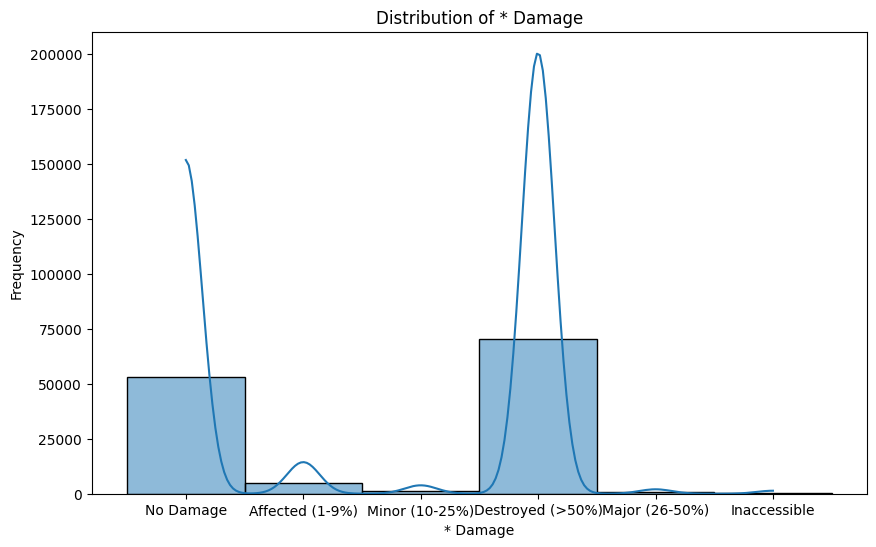

In [86]:
# Data Visualization
# Plotting the distribution of '* Damage'
plt.figure(figsize=(10, 6))
sns.histplot(data_cleaned['* Damage'], bins=30, kde=True)
plt.title('Distribution of * Damage')
plt.xlabel('* Damage')
plt.ylabel('Frequency')
plt.show()

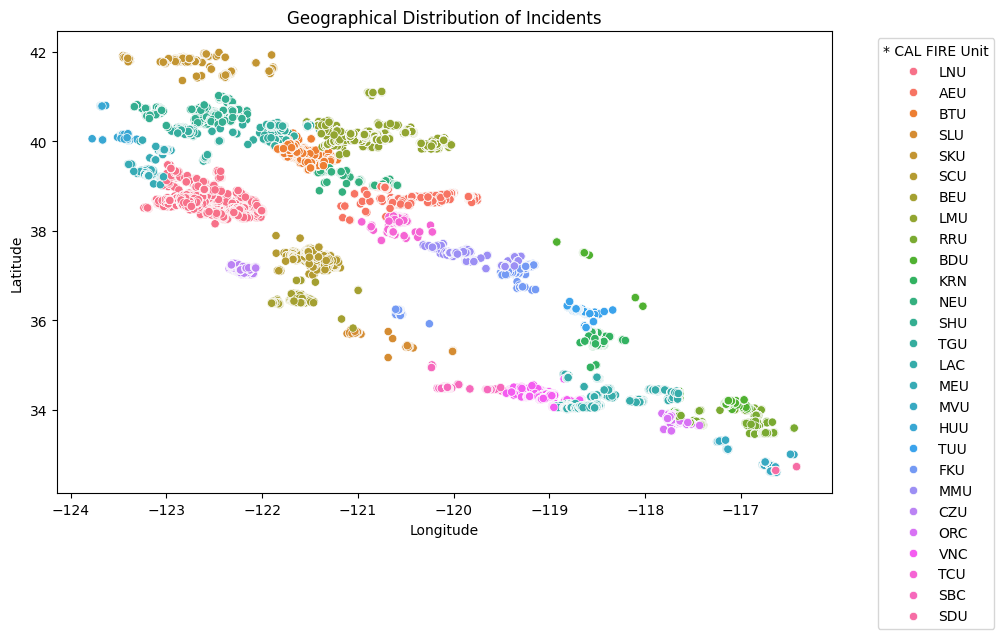

In [87]:
# Scatter plot of 'Latitude' vs 'Longitude' colored by '* CAL FIRE Unit'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Longitude', y='Latitude', hue='* CAL FIRE Unit', data=data_cleaned)
plt.title('Geographical Distribution of Incidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='* CAL FIRE Unit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

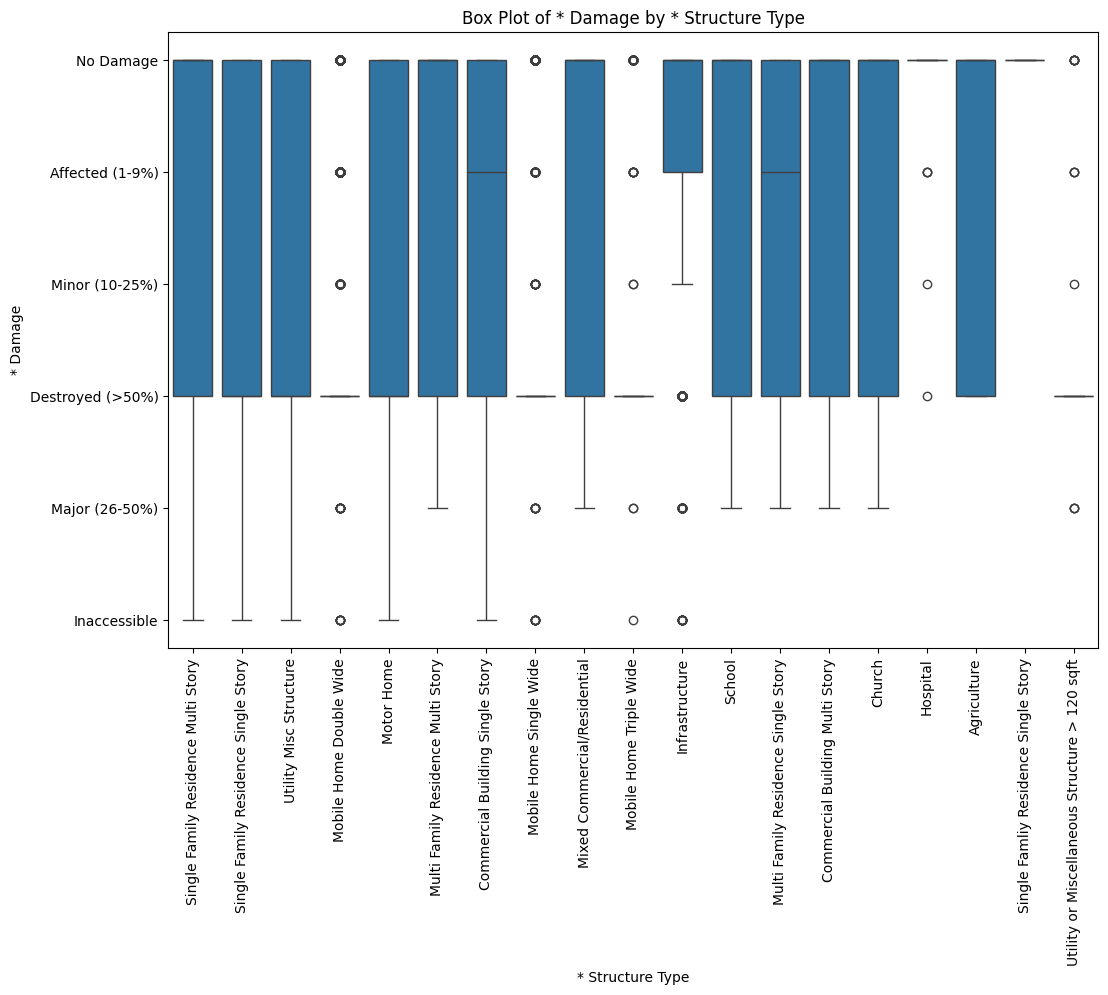

In [88]:
# Box plot of '* Damage' by '* Structure Type'
plt.figure(figsize=(12, 8))
sns.boxplot(x='* Structure Type', y='* Damage', data=data_cleaned)
plt.title('Box Plot of * Damage by * Structure Type')
plt.xlabel('* Structure Type')
plt.ylabel('* Damage')
plt.xticks(rotation=90)
plt.show()

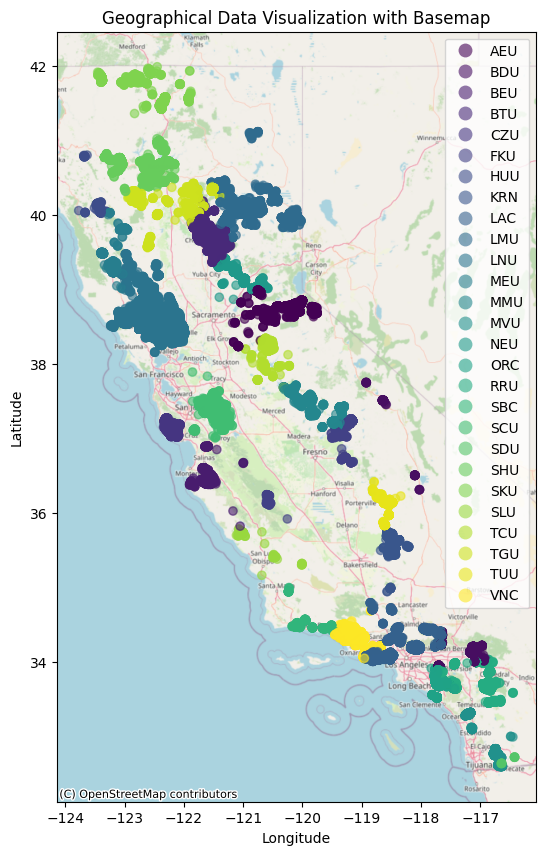

In [89]:
import geopandas as gpd
import contextily as ctx

# Convert the DataFrame to a GeoDataFrame with a specified CRS
gdf = gpd.GeoDataFrame(data_cleaned, geometry=gpd.points_from_xy(data_cleaned.Longitude, data_cleaned.Latitude), crs="EPSG:4326")

# Plot the GeoDataFrame with a basemap
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='* CAL FIRE Unit', cmap='viridis', legend=True, alpha=0.6, ax=ax)

# Use a different basemap source
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Geographical Data Visualization with Basemap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [90]:
from copy import deepcopy

df = deepcopy(data_cleaned)
df.head()

,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)",* City,State,* CAL FIRE Unit,County,* Incident Name,...,* Fence Attached to Structure,APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,x,y
0,1,No Damage,8376.0,Quail Canyon,Road,Winters,CA,LNU,Solano,Quail,...,No Fence,0101090290,510000.0,1997.0,8376 QUAIL CANYON RD VACAVILLE CA 95688,e1919a06-b4c6-476d-99e5-f0b45b070de8,38.474960,-122.044465,-1.358593e+07,4.646741e+06
1,2,Affected (1-9%),8402.0,Quail Canyon,Road,Winters,CA,LNU,Solano,Quail,...,Combustible,0101090270,573052.0,1980.0,8402 QUAIL CANYON RD VACAVILLE CA 95688,b090eeb6-5b18-421e-9723-af7c9144587c,38.477442,-122.043252,-1.358579e+07,4.647094e+06
2,3,No Damage,8430.0,Quail Canyon,Road,Winters,CA,LNU,Solano,Quail,...,No Fence,0101090310,350151.0,2004.0,8430 QUAIL CANYON RD VACAVILLE CA 95688,268da70b-753f-46aa-8fb1-327099337395,38.479358,-122.044585,-1.358594e+07,4.647366e+06
3,4,No Damage,3838.0,Putah Creek,Road,Winters,CA,LNU,Solano,Quail,...,No Fence,0103010240,134880.0,1981.0,3838 PUTAH CREEK RD WINTERS CA 95694,64d4a278-5ee9-414a-8bf4-247c5b5c60f9,38.487313,-122.015115,-1.358266e+07,4.648497e+06
4,5,No Damage,3830.0,Putah Creek,Road,Winters,CA,LNU,Solano,Quail,...,No Fence,0103010220,346648.0,1980.0,3830 PUTAH CREEK RD WINTERS CA 95694,1b44b214-01fd-4f06-b764-eb42a1ec93d7,38.485636,-122.016122,-1.358277e+07,4.648259e+06


In [91]:
df.columns

Index(['OBJECTID', '* Damage', '* Street Number', '* Street Name',
       '* Street Type (e.g. road, drive, lane, etc.)', '* City', 'State',
       '* CAL FIRE Unit', 'County', '* Incident Name',
       'Incident Number (e.g. CAAEU 123456)', 'Incident Start Date',
       'Hazard Type', '* Structure Type', 'Structure Category',
       '* Roof Construction', '* Eaves', '* Vent Screen', '* Exterior Siding',
       '* Window Pane', '* Deck/Porch On Grade', '* Deck/Porch Elevated',
       '* Patio Cover/Carport Attached to Structure',
       '* Fence Attached to Structure', 'APN (parcel)',
       'Assessed Improved Value (parcel)', 'Year Built (parcel)',
       'Site Address (parcel)', 'GLOBALID', 'Latitude', 'Longitude', 'x', 'y'],
      dtype='object')

In [92]:
df[['Incident Start Date','Hazard Type', '* Structure Type', 'Structure Category', '* Roof Construction', '* Eaves', '* Vent Screen', '* Exterior Siding',
       '* Window Pane', '* Deck/Porch On Grade', '* Deck/Porch Elevated','* Patio Cover/Carport Attached to Structure']].head()

,Incident Start Date,Hazard Type,* Structure Type,Structure Category,* Roof Construction,* Eaves,* Vent Screen,* Exterior Siding,* Window Pane,* Deck/Porch On Grade,* Deck/Porch Elevated,* Patio Cover/Carport Attached to Structure
0,6/6/2020 12:00:00 AM,Fire,Single Family Residence Multi Story,Single Residence,Asphalt,Unenclosed,"Mesh Screen <= 1/8""""",Wood,Single Pane,Wood,Wood,No Patio Cover/Carport
1,6/6/2020 12:00:00 AM,Fire,Single Family Residence Single Story,Single Residence,Asphalt,Unenclosed,"Mesh Screen <= 1/8""""",Wood,Multi Pane,Masonry/Concrete,No Deck/Porch,No Patio Cover/Carport
2,6/6/2020 12:00:00 AM,Fire,Single Family Residence Single Story,Single Residence,Asphalt,Enclosed,"Mesh Screen > 1/8""""",Wood,Single Pane,No Deck/Porch,No Deck/Porch,No Patio Cover/Carport
3,6/6/2020 12:00:00 AM,Fire,Single Family Residence Single Story,Single Residence,Asphalt,Unenclosed,"Mesh Screen > 1/8""""",Wood,Single Pane,No Deck/Porch,No Deck/Porch,Combustible
4,6/6/2020 12:00:00 AM,Fire,Single Family Residence Single Story,Single Residence,Tile,Enclosed,"Mesh Screen > 1/8""""",Wood,Multi Pane,Wood,Wood,Combustible


In [93]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Encode the target variable
label_encoder = LabelEncoder()
df['* Damage'] = label_encoder.fit_transform(df['* Damage'])

# Select categorical features, excluding the target variable
categorical_columns = df.select_dtypes(include=['object']).columns

# Encode categorical features using LabelEncoder to reduce memory usage
encoded_data = pd.DataFrame()
for col in categorical_columns:
	encoded_data[col] = label_encoder.fit_transform(df[col].astype(str))

# Define numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Scale numerical features
scaler = MinMaxScaler()
scaled_numerical_data = pd.DataFrame(scaler.fit_transform(df[numerical_columns]), columns=numerical_columns)

# Combine scaled numerical and encoded categorical features
features = pd.concat([scaled_numerical_data, encoded_data], axis=1)

# Handle missing values by filling NaN with 0
features = features.fillna(0)

# Perform chi-square test
chi_scores, p_values = chi2(features, df['* Damage'])

# Create a DataFrame to display results
chi2_results = pd.DataFrame({'Feature': features.columns, 'Chi2 Score': chi_scores, 'P-Value': p_values})
chi2_results = chi2_results.sort_values(by='Chi2 Score', ascending=False)

# Display the top features
print(chi2_results.head(10))

                                Feature    Chi2 Score  P-Value
29                         APN (parcel)  5.905148e+06      0.0
30                Site Address (parcel)  2.636436e+06      0.0
16                  Incident Start Date  5.833792e+05      0.0
8                         * Street Name  5.550584e+05      0.0
10                               * City  1.329397e+05      0.0
15  Incident Number (e.g. CAAEU 123456)  7.557865e+04      0.0
14                      * Incident Name  6.891972e+04      0.0
31                             GLOBALID  5.739395e+04      0.0
23                    * Exterior Siding  3.714869e+04      0.0
13                               County  2.516821e+04      0.0


In [94]:
df.head()

,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)",* City,State,* CAL FIRE Unit,County,* Incident Name,...,* Fence Attached to Structure,APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,x,y
0,1,5,8376.0,Quail Canyon,Road,Winters,CA,LNU,Solano,Quail,...,No Fence,0101090290,510000.0,1997.0,8376 QUAIL CANYON RD VACAVILLE CA 95688,e1919a06-b4c6-476d-99e5-f0b45b070de8,38.474960,-122.044465,-1.358593e+07,4.646741e+06
1,2,0,8402.0,Quail Canyon,Road,Winters,CA,LNU,Solano,Quail,...,Combustible,0101090270,573052.0,1980.0,8402 QUAIL CANYON RD VACAVILLE CA 95688,b090eeb6-5b18-421e-9723-af7c9144587c,38.477442,-122.043252,-1.358579e+07,4.647094e+06
2,3,5,8430.0,Quail Canyon,Road,Winters,CA,LNU,Solano,Quail,...,No Fence,0101090310,350151.0,2004.0,8430 QUAIL CANYON RD VACAVILLE CA 95688,268da70b-753f-46aa-8fb1-327099337395,38.479358,-122.044585,-1.358594e+07,4.647366e+06
3,4,5,3838.0,Putah Creek,Road,Winters,CA,LNU,Solano,Quail,...,No Fence,0103010240,134880.0,1981.0,3838 PUTAH CREEK RD WINTERS CA 95694,64d4a278-5ee9-414a-8bf4-247c5b5c60f9,38.487313,-122.015115,-1.358266e+07,4.648497e+06
4,5,5,3830.0,Putah Creek,Road,Winters,CA,LNU,Solano,Quail,...,No Fence,0103010220,346648.0,1980.0,3830 PUTAH CREEK RD WINTERS CA 95694,1b44b214-01fd-4f06-b764-eb42a1ec93d7,38.485636,-122.016122,-1.358277e+07,4.648259e+06


In [95]:
df.drop(columns=[ 'OBJECTID', 'GLOBALID', 'Site Address (parcel)',
                 'Incident Start Date','APN (parcel)', 'Incident Number (e.g. CAAEU 123456)',
                 'x', 'y', 'Latitude', 'Longitude','* Street Number',
                 'Assessed Improved Value (parcel)','Year Built (parcel)',
                 '* Street Name', '* CAL FIRE Unit','State','* City','County',
                 '* Incident Name', '* Street Type (e.g. road, drive, lane, etc.)'
                 ], inplace=True)

df.head()

,* Damage,Hazard Type,* Structure Type,Structure Category,* Roof Construction,* Eaves,* Vent Screen,* Exterior Siding,* Window Pane,* Deck/Porch On Grade,* Deck/Porch Elevated,* Patio Cover/Carport Attached to Structure,* Fence Attached to Structure
0,5,Fire,Single Family Residence Multi Story,Single Residence,Asphalt,Unenclosed,"Mesh Screen <= 1/8""""",Wood,Single Pane,Wood,Wood,No Patio Cover/Carport,No Fence
1,0,Fire,Single Family Residence Single Story,Single Residence,Asphalt,Unenclosed,"Mesh Screen <= 1/8""""",Wood,Multi Pane,Masonry/Concrete,No Deck/Porch,No Patio Cover/Carport,Combustible
2,5,Fire,Single Family Residence Single Story,Single Residence,Asphalt,Enclosed,"Mesh Screen > 1/8""""",Wood,Single Pane,No Deck/Porch,No Deck/Porch,No Patio Cover/Carport,No Fence
3,5,Fire,Single Family Residence Single Story,Single Residence,Asphalt,Unenclosed,"Mesh Screen > 1/8""""",Wood,Single Pane,No Deck/Porch,No Deck/Porch,Combustible,No Fence
4,5,Fire,Single Family Residence Single Story,Single Residence,Tile,Enclosed,"Mesh Screen > 1/8""""",Wood,Multi Pane,Wood,Wood,Combustible,No Fence


In [96]:
df.columns

Index(['* Damage', 'Hazard Type', '* Structure Type', 'Structure Category',
       '* Roof Construction', '* Eaves', '* Vent Screen', '* Exterior Siding',
       '* Window Pane', '* Deck/Porch On Grade', '* Deck/Porch Elevated',
       '* Patio Cover/Carport Attached to Structure',
       '* Fence Attached to Structure'],
      dtype='object')

In [98]:
# Identify categorical columns and numerical columns from the cleaned dataset
cat_columns = df.select_dtypes(include=['object']).columns
num_columns = df.select_dtypes(include=['number']).columns

print("Categorical columns:")
print(cat_columns)
print("\nNumerical columns:")
print(num_columns)

Categorical columns:
Index(['Hazard Type', '* Structure Type', 'Structure Category',
       '* Roof Construction', '* Eaves', '* Vent Screen', '* Exterior Siding',
       '* Window Pane', '* Deck/Porch On Grade', '* Deck/Porch Elevated',
       '* Patio Cover/Carport Attached to Structure',
       '* Fence Attached to Structure'],
      dtype='object')

Numerical columns:
Index(['* Damage'], dtype='object')


In [100]:
for col in cat_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

df.isnull().sum()

* Damage                                       0
Hazard Type                                    0
* Structure Type                               0
Structure Category                             0
* Roof Construction                            0
* Eaves                                        0
* Vent Screen                                  0
* Exterior Siding                              0
* Window Pane                                  0
* Deck/Porch On Grade                          0
* Deck/Porch Elevated                          0
* Patio Cover/Carport Attached to Structure    0
* Fence Attached to Structure                  0
dtype: int64

In [102]:
from sklearn.preprocessing import OrdinalEncoder

# Initialize the OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Apply ordinal encoding to categorical columns
df = df.copy()
df[cat_columns] = ordinal_encoder.fit_transform(df[cat_columns])

# Display the first few rows of the encoded dataframe
df.head()

,* Damage,Hazard Type,* Structure Type,Structure Category,* Roof Construction,* Eaves,* Vent Screen,* Exterior Siding,* Window Pane,* Deck/Porch On Grade,* Deck/Porch Elevated,* Patio Cover/Carport Attached to Structure,* Fence Attached to Structure
0,5,1.0,14.0,6.0,1.0,5.0,5.0,10.0,6.0,5.0,5.0,2.0,1.0
1,0,1.0,15.0,6.0,1.0,5.0,5.0,10.0,2.0,2.0,3.0,2.0,0.0
2,5,1.0,15.0,6.0,1.0,2.0,6.0,10.0,6.0,3.0,3.0,2.0,1.0
3,5,1.0,15.0,6.0,1.0,5.0,6.0,10.0,6.0,3.0,3.0,1.0,1.0
4,5,1.0,15.0,6.0,9.0,2.0,6.0,10.0,2.0,5.0,5.0,1.0,1.0


In [104]:
X = df.drop('* Damage', axis=1)
y = df['* Damage']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_score, recall_score

# Initialize and train a Logistic Regression model
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
lr_mean_abs_error = mean_absolute_error(y_test, y_pred)
lr_f1_score = f1_score(y_test, y_pred, average='macro')
lr_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
lr_recall = recall_score(y_test, y_pred, average='macro')

print('Logistic Regression')
print('--------------------')
print(f"Accuracy: {accuracy}")
print(f"Mean Absolute Error: {lr_mean_abs_error}")
print(f"F1 Score: {lr_f1_score}")
print(f"Precision: {lr_precision}")
print(f"Recall: {lr_recall}")

Logistic Regression
--------------------
Accuracy: 0.7749091604513291
Mean Absolute Error: 0.8292598967297763
F1 Score: 0.2648891645105066
Precision: 0.2571086638304084
Recall: 0.2739498308088997


In [106]:
# Classification Report
print('---------------------')
print('Classification Report')
print('---------------------')
print(classification_report(y_test, y_pred, zero_division=0))

---------------------
Classification Report
---------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       951
           1       0.82      0.81      0.82     14155
           2       0.00      0.00      0.00        91
           3       0.00      0.00      0.00       131
           4       0.00      0.00      0.00       281
           5       0.72      0.83      0.77     10536

    accuracy                           0.77     26145
   macro avg       0.26      0.27      0.26     26145
weighted avg       0.74      0.77      0.75     26145



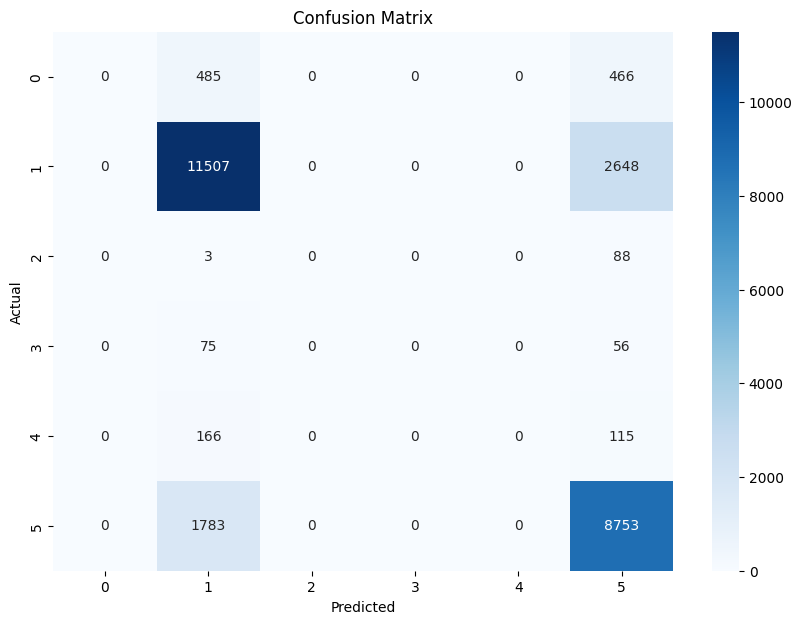

In [107]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [109]:
# Perform SMOTE on Logistic Regression
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check the class distribution before SMOTE
print("Before SMOTE:", Counter(y_train))

Before SMOTE: Counter({1: 55973, 5: 42515, 0: 4074, 4: 1056, 3: 574, 2: 385})


In [110]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print('--------------------------------')
print("After SMOTE:", Counter(y_train_smote))
print('--------------------------------')

# Train the Logistic Regression model on the SMOTE data
lr_smote = LogisticRegression(max_iter=10000)
lr_smote.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_smote = lr_smote.predict(X_test)

# Evaluate the model's performance
accuracy_smote = accuracy_score(y_test, y_pred_smote)
f1_score_smote = f1_score(y_test, y_pred_smote, average='macro')
precision_smote = precision_score(y_test, y_pred_smote, average='macro', 
                                  zero_division=0)
recall_smote = recall_score(y_test, y_pred_smote, average='macro')

print('------------------------------')
print('Logistic Regression with SMOTE')
print('------------------------------')
print(f"Accuracy: {accuracy_smote}")
print(f"F1 Score: {f1_score_smote}")
print(f"Precision: {precision_smote}")
print(f"Recall: {recall_smote}")

--------------------------------
After SMOTE: Counter({5: 55973, 1: 55973, 0: 55973, 4: 55973, 3: 55973, 2: 55973})
--------------------------------
------------------------------
Logistic Regression with SMOTE
------------------------------
Accuracy: 0.5002868617326449
F1 Score: 0.24649546359251304
Precision: 0.28749119193525413
Recall: 0.46522046066959793


In [111]:
# Classification Report on SMOTE Logistic Regression
print('--------------------------------------------------')
print('Classification Report on SMOTE Logistic Regression')
print('--------------------------------------------------')
print(classification_report(y_test, y_pred_smote,
                            zero_division=0))

--------------------------------------------------
Classification Report on SMOTE Logistic Regression
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.06      0.22      0.10       951
           1       0.91      0.59      0.72     14155
           2       0.03      0.95      0.06        91
           3       0.02      0.43      0.04       131
           4       0.04      0.20      0.06       281
           5       0.67      0.40      0.50     10536

    accuracy                           0.50     26145
   macro avg       0.29      0.47      0.25     26145
weighted avg       0.76      0.50      0.60     26145



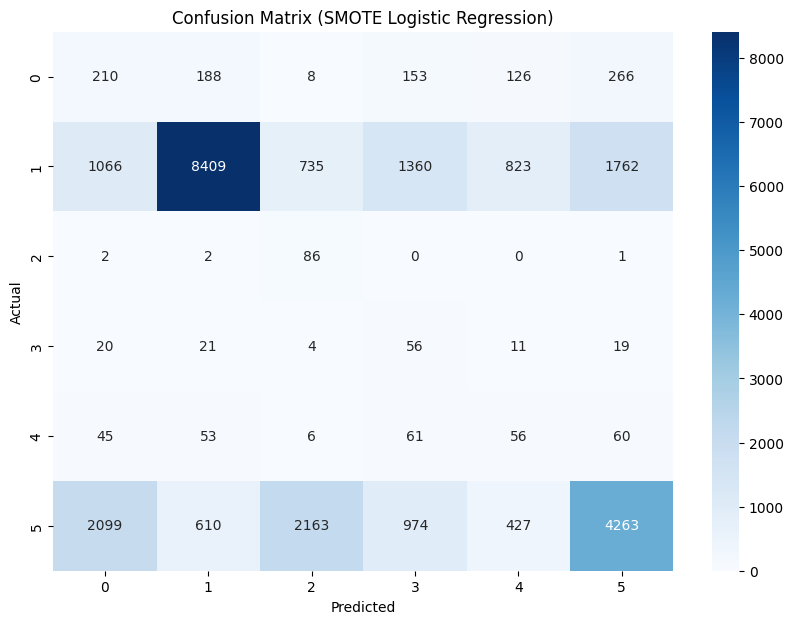

In [112]:
# Confusion Matrix for SMOTE Logistic Regression
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (SMOTE Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

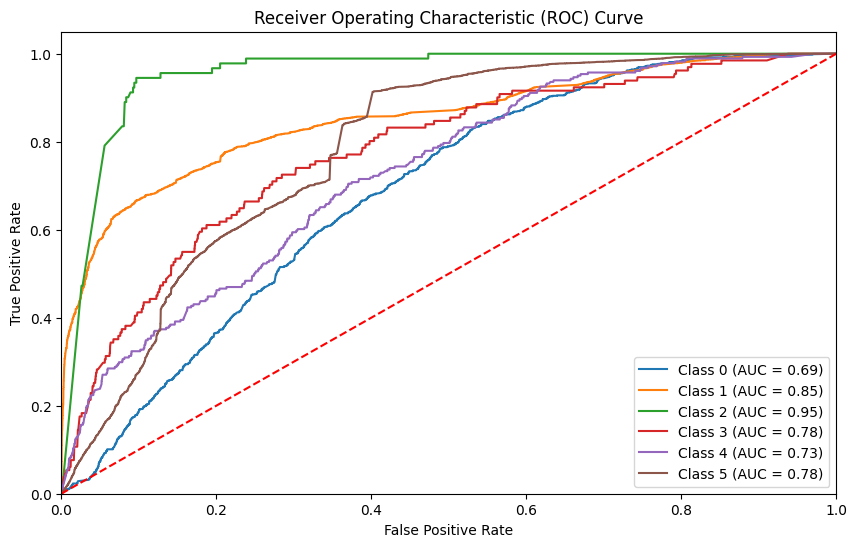

In [115]:
# ROC Curve for SMOTE Logistic Regression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multiclass ROC
classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
y_pred_prob = lr_smote.predict_proba(X_test)

# Plot the ROC curve for each class
plt.figure(figsize=(10, 6))
for i, class_label in enumerate(classes):
	fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
	roc_auc = auc(fpr, tpr)
	plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [118]:
# Perform SMOTE for oversampling
from imblearn.over_sampling import ADASYN

# Initialize ADASYN
adasyn = ADASYN(random_state=42)

# Apply ADASYN to the training data
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Check the class distribution after ADASYN
print('--------------------------------')
print("After ADASYN:", Counter(y_train_adasyn))
print('--------------------------------')

# Train the Logistic Regression model on the ADASYN data
lr_adasyn = LogisticRegression(max_iter=10000)
lr_adasyn.fit(X_train_adasyn, y_train_adasyn)

# Make predictions on the test set
y_pred_adasyn = lr_adasyn.predict(X_test)

# Evaluate the model's performance
accuracy_adasyn = accuracy_score(y_test, y_pred_adasyn)
f1_score_adasyn = f1_score(y_test, y_pred_adasyn, average='macro')
precision_adasyn = precision_score(y_test, y_pred_adasyn, average='macro', zero_division=0)
recall_adasyn = recall_score(y_test, y_pred_adasyn, average='macro')

print('-------------------------------')
print('Logistic Regression with ADASYN')
print('-------------------------------')
print(f"Accuracy: {accuracy_adasyn}")
print(f"F1 Score: {f1_score_adasyn}")
print(f"Precision: {precision_adasyn}")
print(f"Recall: {recall_adasyn}")

--------------------------------
After ADASYN: Counter({5: 56528, 2: 56115, 1: 55973, 3: 55895, 4: 55861, 0: 55107})
--------------------------------
-------------------------------
Logistic Regression with ADASYN
-------------------------------
Accuracy: 0.5037292025243832
F1 Score: 0.2476065688142007
Precision: 0.28760586653494097
Recall: 0.4662002290289939


In [119]:
# Perform classification report on ADASYN Logistic Regression
print('---------------------------------------------------')
print('Classification Report on ADASYN Logistic Regression')
print('---------------------------------------------------')
print(classification_report(y_test, y_pred_adasyn, zero_division=0))

---------------------------------------------------
Classification Report on ADASYN Logistic Regression
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.06      0.22      0.09       951
           1       0.91      0.60      0.72     14155
           2       0.03      0.95      0.06        91
           3       0.02      0.44      0.04       131
           4       0.04      0.20      0.07       281
           5       0.66      0.40      0.50     10536

    accuracy                           0.50     26145
   macro avg       0.29      0.47      0.25     26145
weighted avg       0.76      0.50      0.60     26145



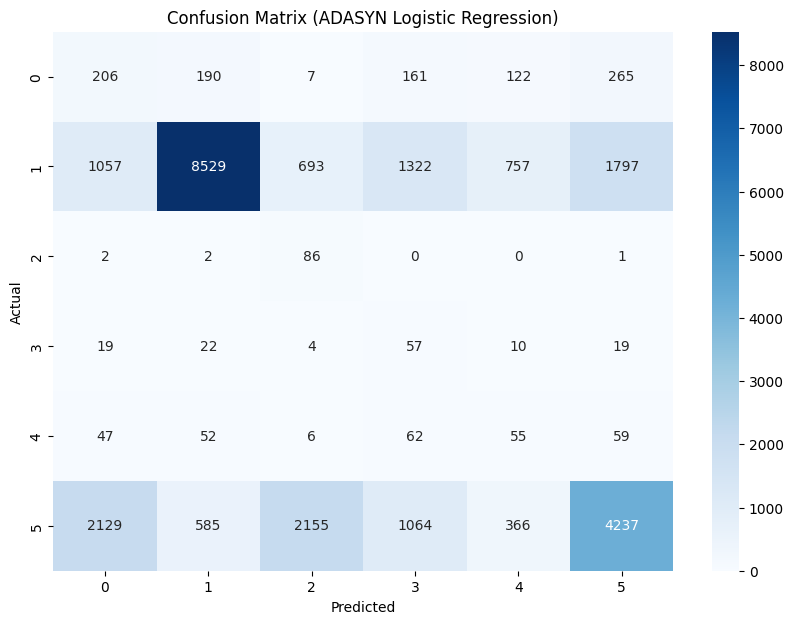

In [120]:
# Confusion Matrix for ADASYN Logistic Regression
conf_matrix_adasyn = confusion_matrix(y_test, y_pred_adasyn)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_adasyn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (ADASYN Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

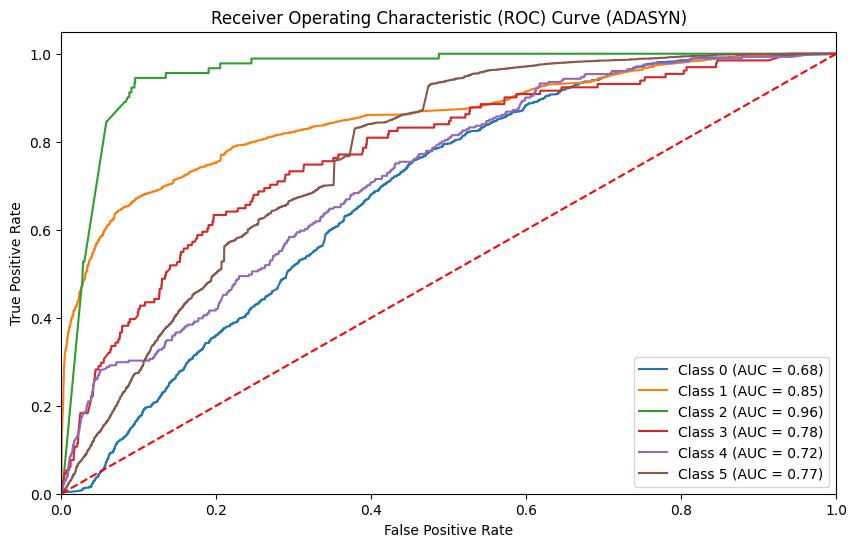

In [121]:
# Perform ROC Curve for ADASYN Logistic Regression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multiclass ROC
classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
y_pred_prob_adasyn = lr_adasyn.predict_proba(X_test)

# Plot the ROC curve for each class
plt.figure(figsize=(10, 6))

for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob_adasyn[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
    
# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (ADASYN)')
plt.legend(loc='lower right')
plt.show()

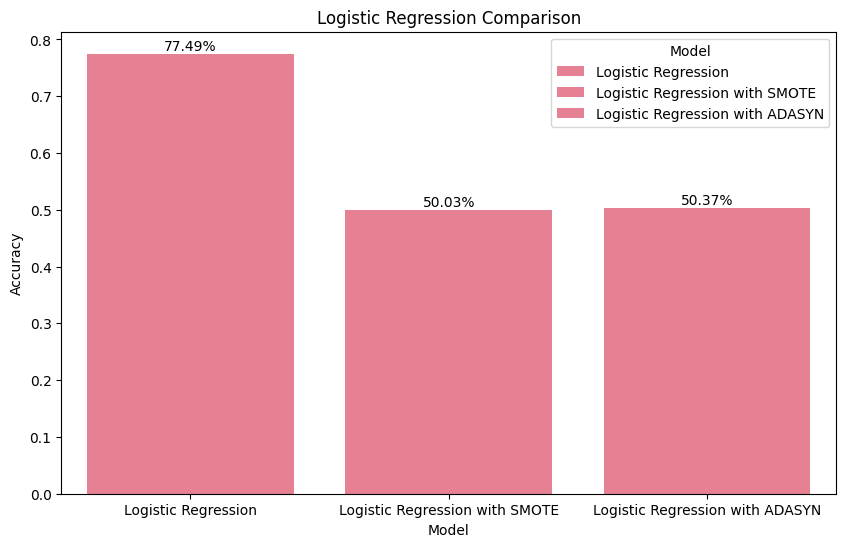

In [128]:
# Plot Logistic Regression Comparison bar chart
plt.figure(figsize=(10, 6))
sns.set_palette("husl")
ax = sns.barplot(x=['Logistic Regression', 'Logistic Regression with SMOTE', 'Logistic Regression with ADASYN'],
                 y=[accuracy, accuracy_smote, accuracy_adasyn])

# Add labels for the legend
for bar, label in zip(ax.patches, ['Logistic Regression', 'Logistic Regression with SMOTE', 'Logistic Regression with ADASYN']):
    bar.set_label(label)

# Add percentages on top of each bar
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2%}', ha='center', va='bottom')

# Add title and labels
plt.title('Logistic Regression Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(fontsize=10)
plt.legend(title='Model', loc='upper right')

# Add legend
plt.show()

In [129]:
# Perform Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Initialize and train a Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf.predict(X_test)
# Evaluate the model's accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
rf_mean_abs_error = mean_absolute_error(y_test, y_pred_rf)
rf_f1_score = f1_score(y_test, y_pred_rf, average='macro')
rf_precision = precision_score(y_test, y_pred_rf, average='macro', zero_division=0)
rf_recall = recall_score(y_test, y_pred_rf, average='macro')

print('------------------------')
print('Random Forest Classifier')
print('------------------------')
print(f"Accuracy: {accuracy_rf}")
print(f"Mean Absolute Error: {rf_mean_abs_error}")
print(f"F1 Score: {rf_f1_score}")
print(f"Precision: {rf_precision}")

------------------------
Random Forest Classifier
------------------------
Accuracy: 0.8530885446548098
Mean Absolute Error: 0.52067316886594
F1 Score: 0.3220022960167681
Precision: 0.3875252556123658


In [130]:
# Classification Report for Random Forest Classifier
print('--------------------------------------------------')
print('Classification Report for Random Forest Classifier')
print('--------------------------------------------------')
print(classification_report(y_test, y_pred_rf, zero_division=0))

--------------------------------------------------
Classification Report for Random Forest Classifier
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.25      0.07      0.10       951
           1       0.91      0.89      0.90     14155
           2       0.17      0.01      0.02        91
           3       0.10      0.02      0.03       131
           4       0.10      0.01      0.02       281
           5       0.81      0.92      0.86     10536

    accuracy                           0.85     26145
   macro avg       0.39      0.32      0.32     26145
weighted avg       0.83      0.85      0.84     26145



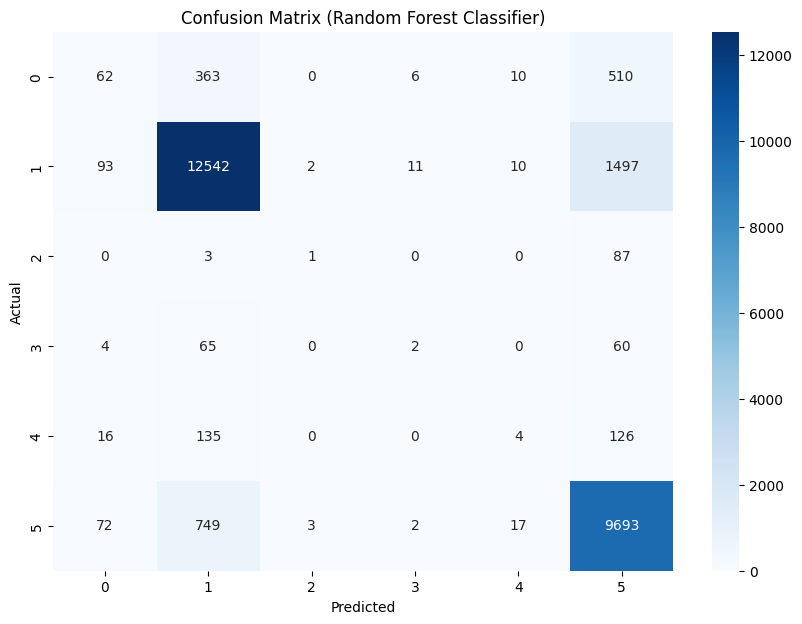

In [ ]:
# Confusion Matrix for Random Forest Classifier
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Forest Classifier)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

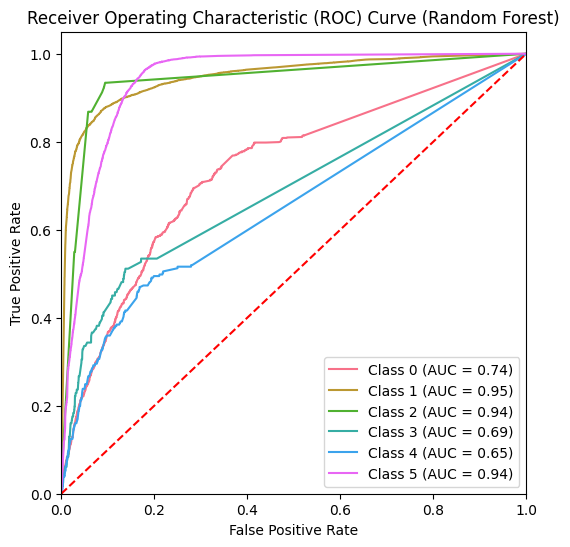

In [139]:
# ROC Curve for Random Forest Classifier
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import label_binarize

# Binarize the labels for multiclass ROC
classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
y_pred_prob_rf = rf.predict_proba(X_test)

# Plot the ROC curve for each class
plt.figure(figsize=(6, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
    
# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Random Forest)')
plt.legend(loc='lower right')
plt.show()

In [133]:
# Perform SMOTE on Random Forest Classifier
from imblearn.over_sampling import SMOTE

from collections import Counter

# Check the class distribution before SMOTE
print("Before SMOTE:", Counter(y_train))

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print('--------------------------------')
print("After SMOTE:", Counter(y_train_smote))
print('--------------------------------')

# Train the Random Forest Classifier model on the SMOTE data
rf_smote = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_smote.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_rf_smote = rf_smote.predict(X_test)
# Evaluate the model's performance
accuracy_rf_smote = accuracy_score(y_test, y_pred_rf_smote)
rf_f1_score_smote = f1_score(y_test, y_pred_rf_smote, average='macro')
rf_precision_smote = precision_score(y_test, y_pred_rf_smote, average='macro', zero_division=0)
rf_recall_smote = recall_score(y_test, y_pred_rf_smote, average='macro')

print('------------------------')
print('Random Forest with SMOTE')
print('------------------------')
print(f"Accuracy: {accuracy_rf_smote}")
print(f"F1 Score: {rf_f1_score_smote}")
print(f"Precision: {rf_precision_smote}")
print(f"Recall: {rf_recall_smote}")

Before SMOTE: Counter({1: 55973, 5: 42515, 0: 4074, 4: 1056, 3: 574, 2: 385})
--------------------------------
After SMOTE: Counter({5: 55973, 1: 55973, 0: 55973, 4: 55973, 3: 55973, 2: 55973})
--------------------------------
------------------------
Random Forest with SMOTE
------------------------
Accuracy: 0.7366991776630331
F1 Score: 0.3330045442515617
Precision: 0.33554138085308516
Recall: 0.48261089916782723


In [134]:
# Classification Report for Random Forest with SMOTE
print('--------------------------------------------------')
print('Classification Report for Random Forest with SMOTE')
print('--------------------------------------------------')
print(classification_report(y_test, y_pred_rf_smote, zero_division=0))

--------------------------------------------------
Classification Report for Random Forest with SMOTE
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.14      0.18      0.16       951
           1       0.93      0.82      0.87     14155
           2       0.04      0.90      0.07        91
           3       0.04      0.18      0.07       131
           4       0.07      0.11      0.08       281
           5       0.80      0.70      0.74     10536

    accuracy                           0.74     26145
   macro avg       0.34      0.48      0.33     26145
weighted avg       0.83      0.74      0.78     26145



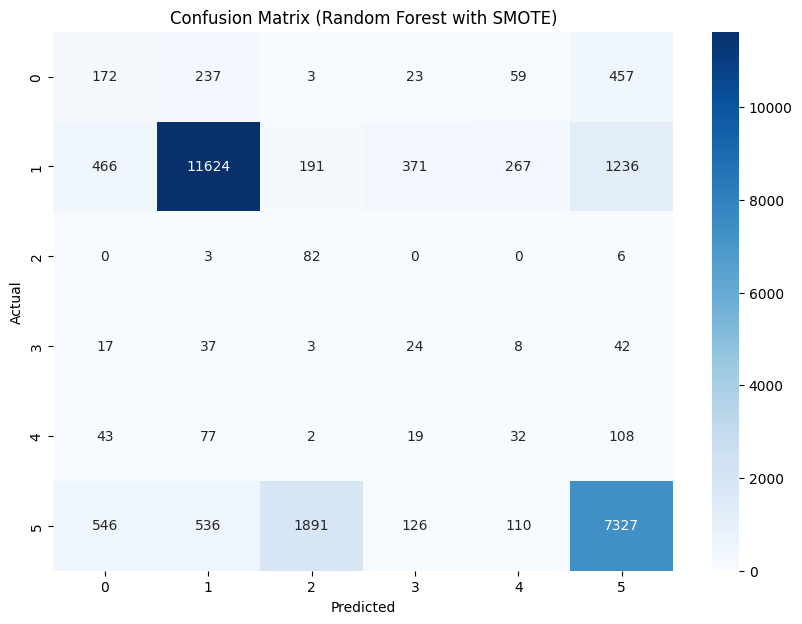

In [135]:
# Confusion Matrix for Random Forest with SMOTE
conf_matrix_rf_smote = confusion_matrix(y_test, y_pred_rf_smote)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Forest with SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

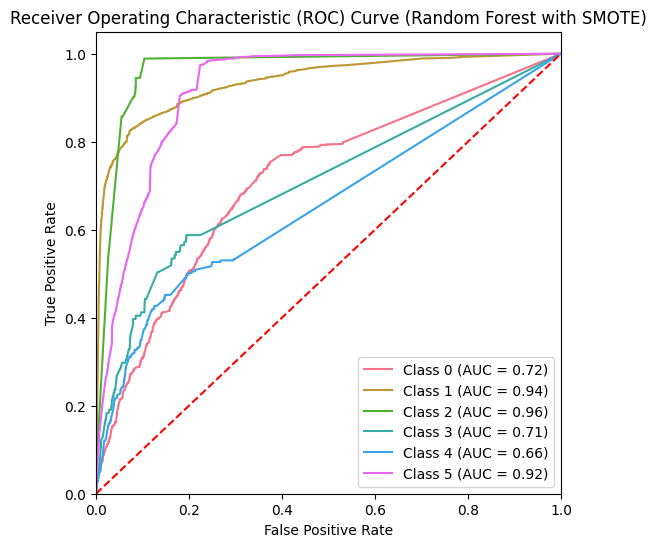

In [138]:
# ROC Curve for Random Forest with SMOTE
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multiclass ROC
classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
y_pred_prob_rf_smote = rf_smote.predict_proba(X_test)

# Plot the ROC curve for each class
plt.figure(figsize=(6, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob_rf_smote[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
    
# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Random Forest with SMOTE)')
plt.legend(loc='lower right')
plt.show()

In [140]:
# Perform ADASYN on Random Forest Classifier
from imblearn.over_sampling import ADASYN
from collections import Counter

# Check the class distribution before ADASYN
print("Before ADASYN:", Counter(y_train))

# Initialize ADASYN
adasyn = ADASYN(random_state=42)

# Apply ADASYN to the training data
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Check the class distribution after ADASYN
print('--------------------------------')
print("After ADASYN:", Counter(y_train_adasyn))
print('--------------------------------')
# Train the Random Forest Classifier model on the ADASYN data
rf_adasyn = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_adasyn.fit(X_train_adasyn, y_train_adasyn)

# Make predictions on the test set
y_pred_rf_adasyn = rf_adasyn.predict(X_test)
# Evaluate the model's performance
accuracy_rf_adasyn = accuracy_score(y_test, y_pred_rf_adasyn)
rf_f1_score_adasyn = f1_score(y_test, y_pred_rf_adasyn, average='macro')
rf_precision_adasyn = precision_score(y_test, y_pred_rf_adasyn, average='macro', zero_division=0)
rf_recall_adasyn = recall_score(y_test, y_pred_rf_adasyn, average='macro')

print('-------------------------')
print('Random Forest with ADASYN')
print('-------------------------')
print(f"Accuracy: {accuracy_rf_adasyn}")
print(f"F1 Score: {rf_f1_score_adasyn}")
print(f"Precision: {rf_precision_adasyn}")
print(f"Recall: {rf_recall_adasyn}")

Before ADASYN: Counter({1: 55973, 5: 42515, 0: 4074, 4: 1056, 3: 574, 2: 385})
--------------------------------
After ADASYN: Counter({5: 56528, 2: 56115, 1: 55973, 3: 55895, 4: 55861, 0: 55107})
--------------------------------
-------------------------
Random Forest with ADASYN
-------------------------
Accuracy: 0.7343277873398355
F1 Score: 0.32966997114581104
Precision: 0.3329195891459733
Recall: 0.47863169136547246


In [141]:
# Classification Report for Random Forest with ADASYN
print('---------------------------------------------------')
print('Classification Report for Random Forest with ADASYN')
print('---------------------------------------------------')
print(classification_report(y_test, y_pred_rf_adasyn, zero_division=0))

---------------------------------------------------
Classification Report for Random Forest with ADASYN
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.13      0.15      0.14       951
           1       0.93      0.81      0.87     14155
           2       0.04      0.90      0.07        91
           3       0.04      0.16      0.06       131
           4       0.07      0.15      0.09       281
           5       0.79      0.70      0.74     10536

    accuracy                           0.73     26145
   macro avg       0.33      0.48      0.33     26145
weighted avg       0.83      0.73      0.78     26145



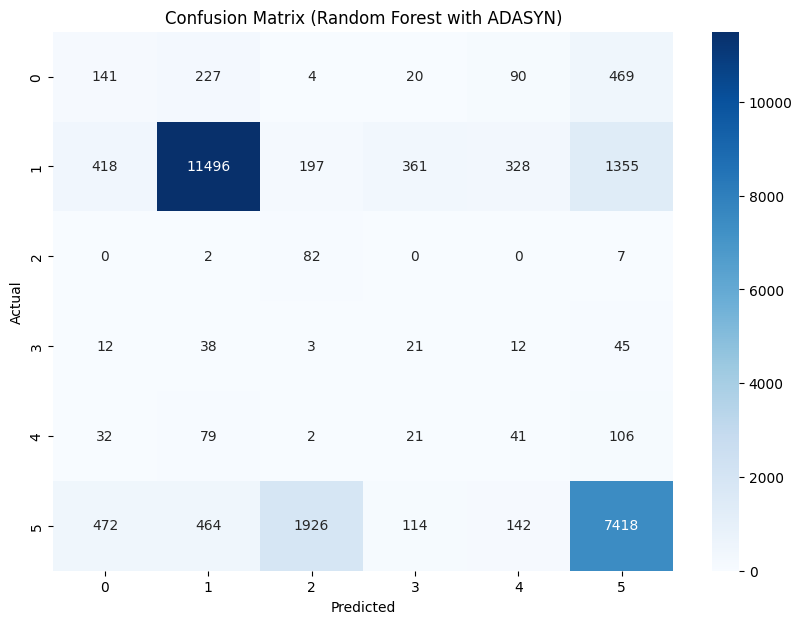

In [142]:
# Confusion Matrix for Random Forest with ADASYN
conf_matrix_rf_adasyn = confusion_matrix(y_test, y_pred_rf_adasyn)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf_adasyn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Forest with ADASYN)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

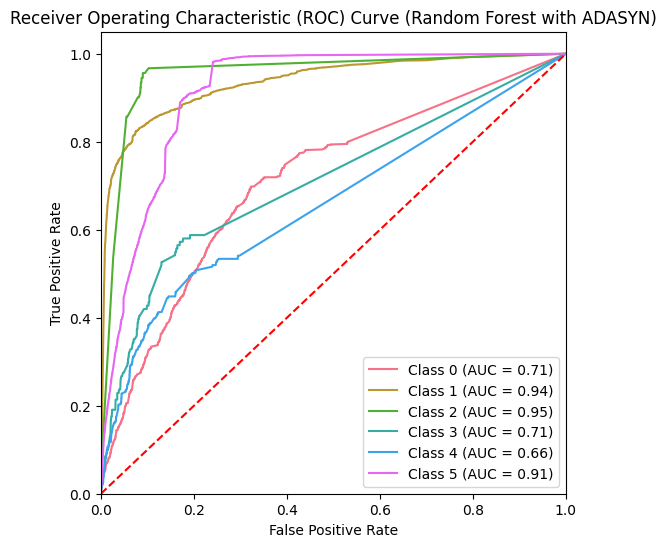

In [143]:
# ROC Curve for Random Forest with ADASYN
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multiclass ROC
classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
y_pred_prob_rf_adasyn = rf_adasyn.predict_proba(X_test)

# Plot the ROC curve for each class
plt.figure(figsize=(6, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob_rf_adasyn[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
    
# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Random Forest with ADASYN)')
plt.legend(loc='lower right')
plt.show()

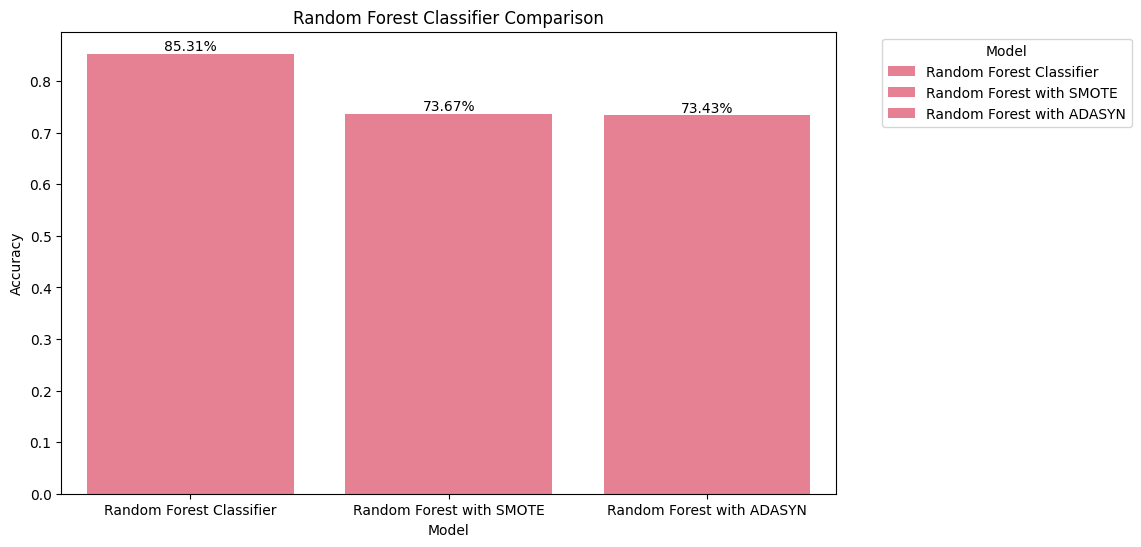

In [147]:
# Plot Random Forest Classifier Comparison bar chart
plt.figure(figsize=(10, 6))
sns.set_palette("husl")
ax = sns.barplot(x=['Random Forest Classifier', 'Random Forest with SMOTE', 'Random Forest with ADASYN'],
                 y=[accuracy_rf, accuracy_rf_smote, accuracy_rf_adasyn])

# Add labels for the legend
for bar, label in zip(ax.patches, ['Random Forest Classifier', 'Random Forest with SMOTE', 'Random Forest with ADASYN']):
    bar.set_label(label)
    
# Add percentages on top of each bar
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2%}', ha='center', va='bottom')
    
# Add title and labels
plt.title('Random Forest Classifier Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(fontsize=10)
plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1.05, 1))  # Legend outside the graph
plt.show()


In [148]:
# Feature Importance for Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Initialize and train a Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
# Make predictions on the test set
y_pred_dt = dt.predict(X_test)
# Evaluate the model's accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
dt_f1_score = f1_score(y_test, y_pred_dt, average='macro')
dt_precision = precision_score(y_test, y_pred_dt, average='macro', zero_division=0)
dt_recall = recall_score(y_test, y_pred_dt, average='macro')

print('------------------------')
print('Decision Tree Classifier')
print('------------------------')
print(f"Accuracy: {accuracy_dt}")
print(f"F1 Score: {dt_f1_score}")
print(f"Precision: {dt_precision}")
print(f"Recall: {dt_recall}")

------------------------
Decision Tree Classifier
------------------------
Accuracy: 0.8309045706636068
F1 Score: 0.3233328926351156
Precision: 0.34687132601158943
Recall: 0.31950731971750906


In [149]:
# Classification Report for Decision Tree Classifier
print('--------------------------------------------------')
print('Classification Report for Decision Tree Classifier')
print('--------------------------------------------------')
print(classification_report(y_test, y_pred_dt, zero_division=0))

--------------------------------------------------
Classification Report for Decision Tree Classifier
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.15      0.11      0.13       951
           1       0.89      0.88      0.88     14155
           2       0.11      0.01      0.02        91
           3       0.03      0.02      0.02       131
           4       0.08      0.04      0.05       281
           5       0.81      0.87      0.84     10536

    accuracy                           0.83     26145
   macro avg       0.35      0.32      0.32     26145
weighted avg       0.82      0.83      0.82     26145



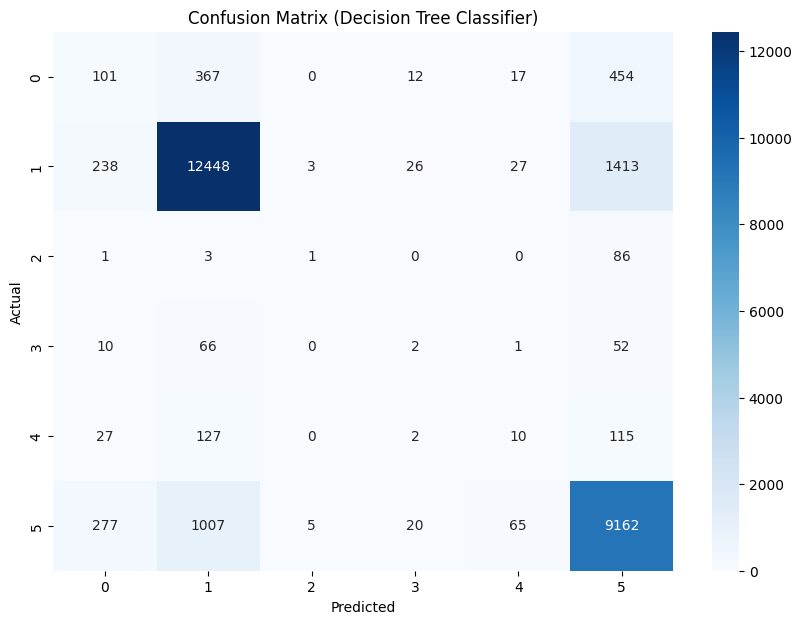

In [150]:
# Confusion Matrix for Decision Tree Classifier
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Decision Tree Classifier)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

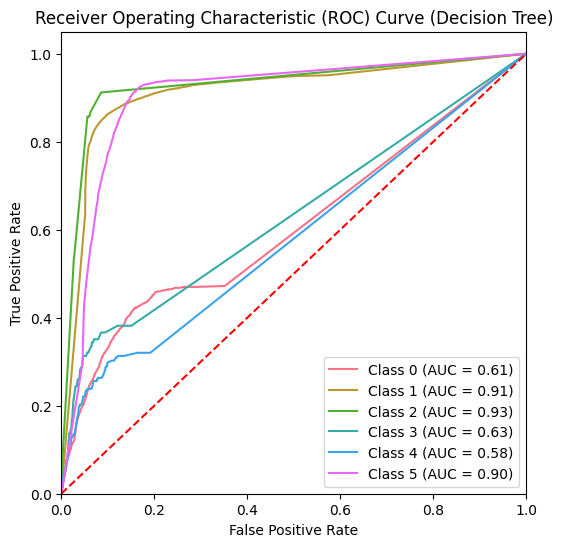

In [151]:
# ROC Curve for Decision Tree Classifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multiclass ROC
classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
y_pred_prob_dt = dt.predict_proba(X_test)

# Plot the ROC curve for each class
plt.figure(figsize=(6, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob_dt[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
    
# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Decision Tree)')
plt.legend(loc='lower right')
plt.show()

In [152]:
# Perform SMOTE on Decision Tree Classifier
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check the class distribution before SMOTE
print("Before SMOTE:", Counter(y_train))

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# Check the class distribution after SMOTE
print('--------------------------------')
print("After SMOTE:", Counter(y_train_smote))
print('--------------------------------')
# Train the Decision Tree Classifier model on the SMOTE data
dt_smote = DecisionTreeClassifier(random_state=42)
dt_smote.fit(X_train_smote, y_train_smote)
# Make predictions on the test set
y_pred_dt_smote = dt_smote.predict(X_test)
# Evaluate the model's performance
accuracy_dt_smote = accuracy_score(y_test, y_pred_dt_smote)
dt_f1_score_smote = f1_score(y_test, y_pred_dt_smote, average='macro')
dt_precision_smote = precision_score(y_test, y_pred_dt_smote, average='macro', zero_division=0)
dt_recall_smote = recall_score(y_test, y_pred_dt_smote, average='macro')

print('------------------------')
print('Decision Tree with SMOTE')
print('------------------------')
print(f"Accuracy: {accuracy_dt_smote}")
print(f"F1 Score: {dt_f1_score_smote}")
print(f"Precision: {dt_precision_smote}")
print(f"Recall: {dt_recall_smote}")

Before SMOTE: Counter({1: 55973, 5: 42515, 0: 4074, 4: 1056, 3: 574, 2: 385})
--------------------------------
After SMOTE: Counter({5: 55973, 1: 55973, 0: 55973, 4: 55973, 3: 55973, 2: 55973})
--------------------------------
------------------------
Decision Tree with SMOTE
------------------------
Accuracy: 0.7160833811436221
F1 Score: 0.3273222989970365
Precision: 0.33071033024925994
Recall: 0.48573094396458744


In [153]:
# Classification Report for Decision Tree with SMOTE
print('--------------------------------------------------')
print('Classification Report for Decision Tree with SMOTE')
print('--------------------------------------------------')
print(classification_report(y_test, y_pred_dt_smote, zero_division=0))

--------------------------------------------------
Classification Report for Decision Tree with SMOTE
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.13      0.22      0.17       951
           1       0.91      0.82      0.86     14155
           2       0.04      0.92      0.07        91
           3       0.04      0.18      0.07       131
           4       0.06      0.12      0.08       281
           5       0.80      0.65      0.72     10536

    accuracy                           0.72     26145
   macro avg       0.33      0.49      0.33     26145
weighted avg       0.82      0.72      0.76     26145



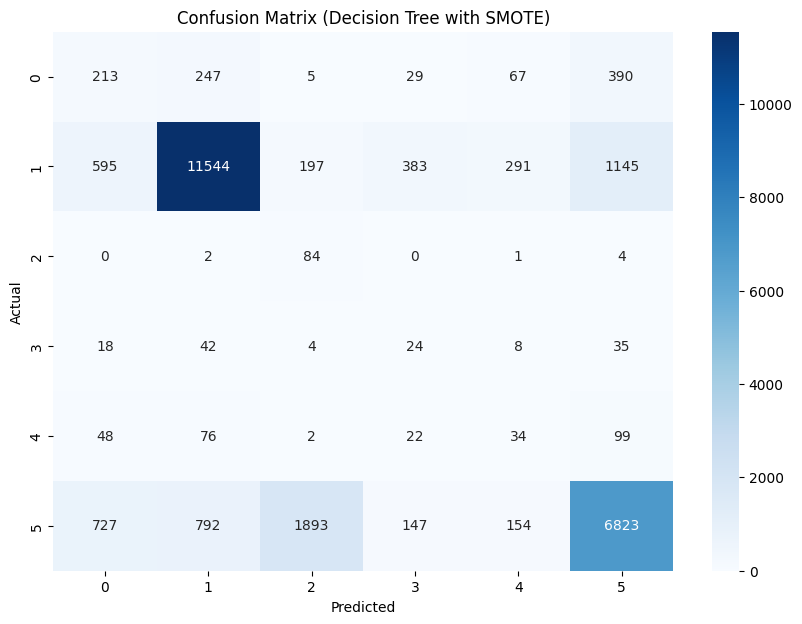

In [154]:
# Confusion Matrix for Decision Tree with SMOTE
conf_matrix_dt_smote = confusion_matrix(y_test, y_pred_dt_smote)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_dt_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Decision Tree with SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

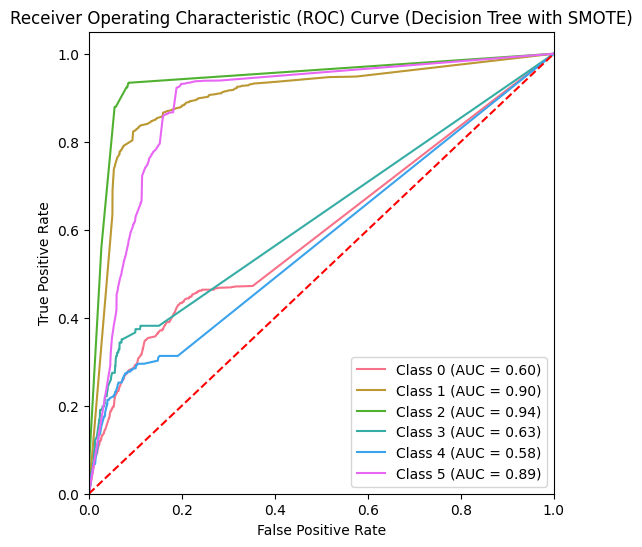

In [155]:
# ROC Curve for Decision Tree with SMOTE
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multiclass ROC
classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
y_pred_prob_dt_smote = dt_smote.predict_proba(X_test)

# Plot the ROC curve for each class
plt.figure(figsize=(6, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob_dt_smote[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
    
# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Decision Tree with SMOTE)')
plt.legend(loc='lower right')
plt.show()

In [156]:
# Perform ADASYN on Decision Tree Classifier
from imblearn.over_sampling import ADASYN
from collections import Counter

# Check the class distribution before ADASYN
print("Before ADASYN:", Counter(y_train))

# Initialize ADASYN
adasyn = ADASYN(random_state=42)

# Apply ADASYN to the training data
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
# Check the class distribution after ADASYN
print('--------------------------------')
print("After ADASYN:", Counter(y_train_adasyn))
print('--------------------------------')

# Train the Decision Tree Classifier model on the ADASYN data
dt_adasyn = DecisionTreeClassifier(random_state=42)
dt_adasyn.fit(X_train_adasyn, y_train_adasyn)
# Make predictions on the test set
y_pred_dt_adasyn = dt_adasyn.predict(X_test)
# Evaluate the model's performance
accuracy_dt_adasyn = accuracy_score(y_test, y_pred_dt_adasyn)
dt_f1_score_adasyn = f1_score(y_test, y_pred_dt_adasyn, average='macro')
dt_precision_adasyn = precision_score(y_test, y_pred_dt_adasyn, average='macro', zero_division=0)
dt_recall_adasyn = recall_score(y_test, y_pred_dt_adasyn, average='macro')

print('-------------------------')
print('Decision Tree with ADASYN')
print('-------------------------')
print(f"Accuracy: {accuracy_dt_adasyn}")
print(f"F1 Score: {dt_f1_score_adasyn}")
print(f"Precision: {dt_precision_adasyn}")
print(f"Recall: {dt_recall_adasyn}")

Before ADASYN: Counter({1: 55973, 5: 42515, 0: 4074, 4: 1056, 3: 574, 2: 385})
--------------------------------
After ADASYN: Counter({5: 56528, 2: 56115, 1: 55973, 3: 55895, 4: 55861, 0: 55107})
--------------------------------
-------------------------
Decision Tree with ADASYN
-------------------------
Accuracy: 0.7136354943583859
F1 Score: 0.32433688600904814
Precision: 0.3280543996920449
Recall: 0.47932711452052934


In [157]:
# Classification Report for Decision Tree with ADASYN
print('---------------------------------------------------')
print('Classification Report for Decision Tree with ADASYN')
print('---------------------------------------------------')
print(classification_report(y_test, y_pred_dt_adasyn, zero_division=0))

---------------------------------------------------
Classification Report for Decision Tree with ADASYN
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.13      0.19      0.15       951
           1       0.91      0.81      0.86     14155
           2       0.04      0.91      0.07        91
           3       0.04      0.16      0.06       131
           4       0.06      0.15      0.09       281
           5       0.79      0.66      0.72     10536

    accuracy                           0.71     26145
   macro avg       0.33      0.48      0.32     26145
weighted avg       0.82      0.71      0.76     26145



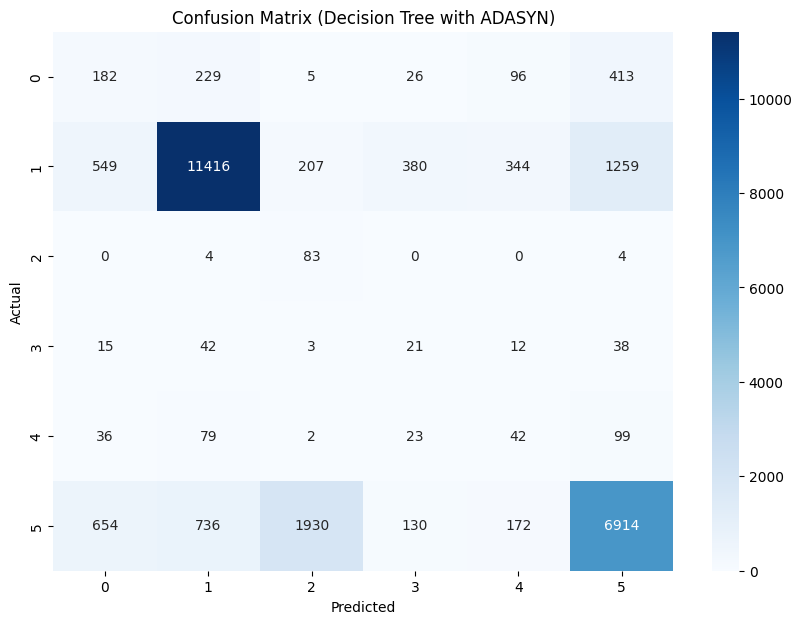

In [158]:
# Confusion Matrix for Decision Tree with ADASYN
conf_matrix_dt_adasyn = confusion_matrix(y_test, y_pred_dt_adasyn)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_dt_adasyn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Decision Tree with ADASYN)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

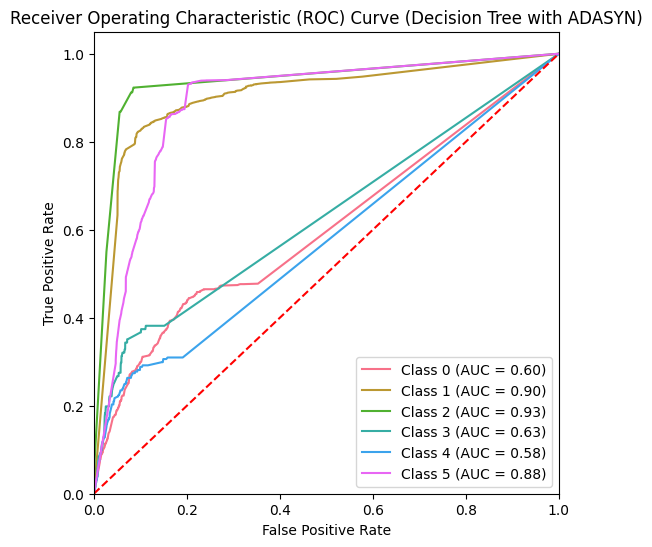

In [159]:
# Perform ROC Curve for Decision Tree with ADASYN
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multiclass ROC
classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
y_pred_prob_dt_adasyn = dt_adasyn.predict_proba(X_test)

# Plot the ROC curve for each class
plt.figure(figsize=(6, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob_dt_adasyn[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
    
# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Decision Tree with ADASYN)')
plt.legend(loc='lower right')
plt.show()

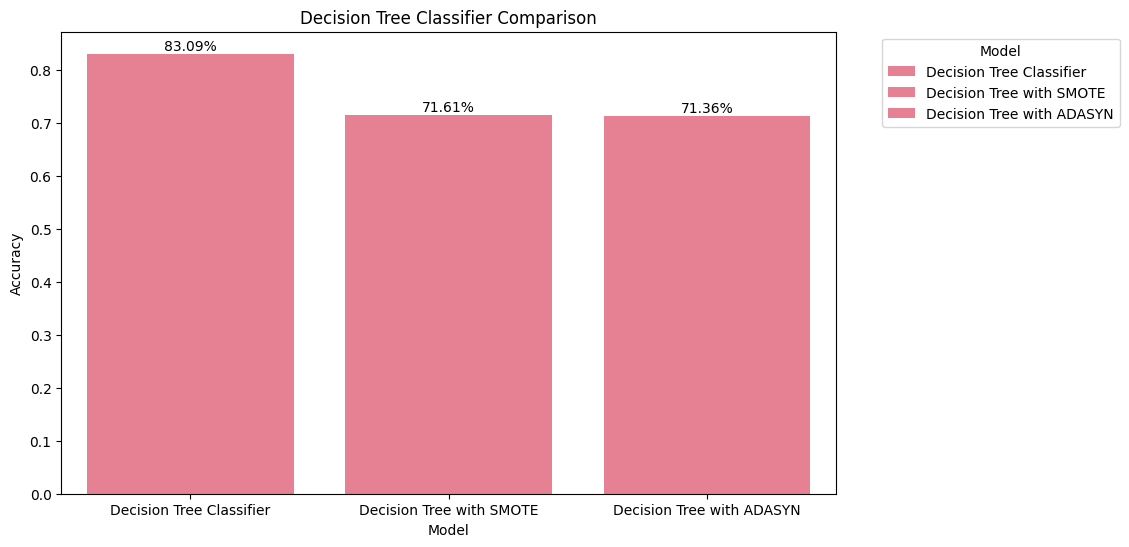

In [160]:
# Plot Decision Tree Classifier Comparison bar chart
plt.figure(figsize=(10, 6))
sns.set_palette("husl")
ax = sns.barplot(x=['Decision Tree Classifier', 'Decision Tree with SMOTE', 'Decision Tree with ADASYN'],
                 y=[accuracy_dt, accuracy_dt_smote, accuracy_dt_adasyn])

# Add labels for the legend
for bar, label in zip(ax.patches, ['Decision Tree Classifier', 'Decision Tree with SMOTE', 'Decision Tree with ADASYN']):
    bar.set_label(label)
    
# Add percentages on top of each bar
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2%}', ha='center', va='bottom')
# Add title and labels
plt.title('Decision Tree Classifier Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(fontsize=10)
plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1.05, 1))  # Legend outside the graph
plt.show()

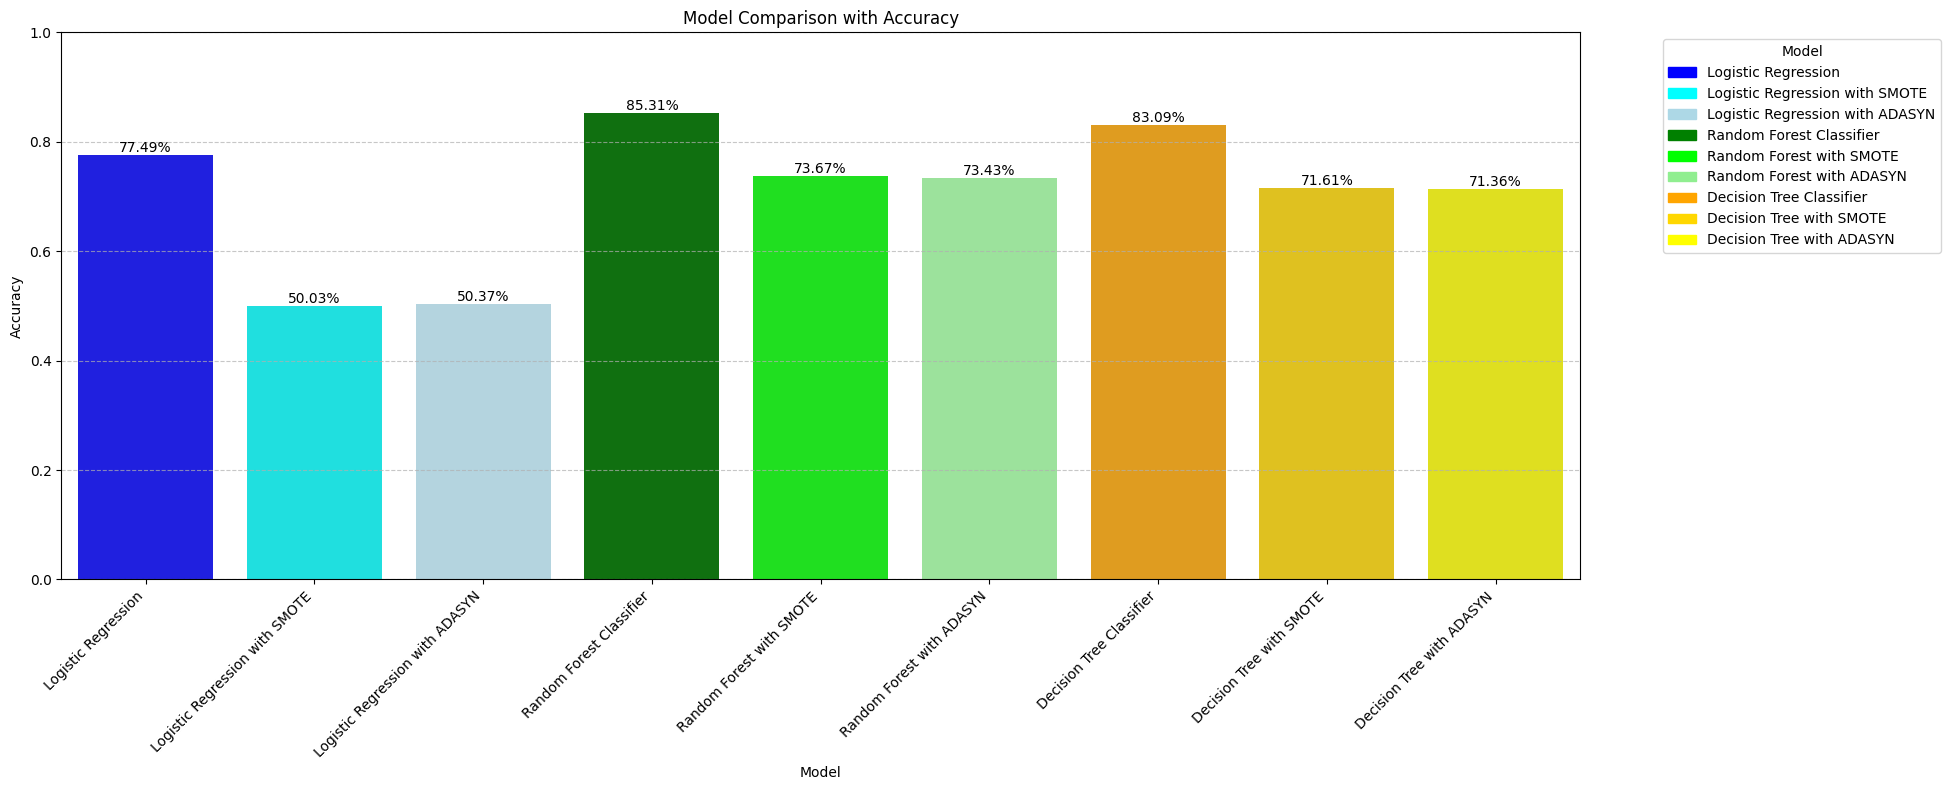

In [178]:
# Plot Logistic Regression, Random Forest, and Decision Tree Classifier Comparison bar chart
import matplotlib.patches as mpatches

plt.figure(figsize=(16, 8))
colors = ['blue', 'cyan', 'lightblue', 'green', 'lime', 'lightgreen', 'orange', 'gold', 'yellow']
models = ['Logistic Regression', 'Logistic Regression with SMOTE', 'Logistic Regression with ADASYN',
          'Random Forest Classifier', 'Random Forest with SMOTE', 'Random Forest with ADASYN',
          'Decision Tree Classifier', 'Decision Tree with SMOTE', 'Decision Tree with ADASYN']
accuracies = [accuracy, accuracy_smote, accuracy_adasyn, accuracy_rf, accuracy_rf_smote, accuracy_rf_adasyn,
              accuracy_dt, accuracy_dt_smote, accuracy_dt_adasyn]

ax = sns.barplot(x=models, y=accuracies, palette=colors, hue=models, dodge=False, legend=False)

# Add percentages on top of each bar
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2%}', ha='center', va='bottom')

# Add title and labels
plt.title('Model Comparison with Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.ylim(0, 1)  # Set y-axis limit to 1 for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
patches = [mpatches.Patch(color=colors[i], label=models[i]) for i in range(len(models))]
plt.legend(handles=patches, title='Model', loc='upper left', bbox_to_anchor=(1.05, 1))  # Legend outside the graph
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.show()